MEM T380

Case Studies Group 10

Ante Sokosa  
Ziad Hatab

Final Project - Weld Defect Classification with Aritifial Neural Networks

In [1]:
# for calculating notebook runtime
import time
start_time = time.time()

In [2]:
import pandas as pd
from pandas.api.types import CategoricalDtype

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV

# 1 &nbsp; `Data Exploration (Access, Preprocessimg, and Deriving Features`

Data exploration has been previously explained, discussed, and completed in HW2.  
We are importing this data as explored, cleaned, and prepared with subsets combined.

Standerdize instead of normalize.

In [22]:
excel_file = 'weld_defect_dataset_semi.xlsx'
df = pd.read_excel(excel_file)

nums = list(df.select_dtypes(include=['float64']).columns)

types = df['type'].unique().tolist()
print(types)

# Specify the order of your categories
cat_type = CategoricalDtype(categories=types, ordered=True)

# Convert your column to the categorical type
df['type'] = df['type'].astype(cat_type)

# get dummies
df = pd.get_dummies(df, columns=['type'])

standard_scaler = StandardScaler()
df[nums] = standard_scaler.fit_transform(df[nums])
df


['PO', 'SL', 'LP', 'LF', 'CR']


,w,ar,sp,re,rr,sk,ku,hc,rc,sc,kc,type_PO,type_SL,type_LP,type_LF,type_CR
0,-0.874553,-0.786637,-0.116198,1.687500,3.592437,-0.462970,2.014749,-0.646807,-0.608549,0.112723,-0.587744,1,0,0,0,0
1,-0.867095,-0.800094,-0.873054,1.687500,1.916513,-0.783785,-0.847640,-0.649219,-0.550744,0.643202,-0.230305,1,0,0,0,0
2,-0.882011,-0.800094,-0.739818,2.324728,2.420339,-0.729491,1.073546,-0.650634,-0.513391,0.576477,-0.225458,1,0,0,0,0
3,-0.770168,-0.800094,-1.330129,0.540485,-0.903687,0.469655,1.223842,-0.597296,-0.716502,-0.141997,-0.921506,1,0,0,0,0
4,-0.822358,-0.800094,-0.913765,0.625398,-1.020156,2.505449,0.173118,-0.620766,-0.824734,0.211772,-1.363982,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,0.527210,2.890215,1.974872,-1.089548,2.270158,-0.870020,-0.899740,0.061944,3.128958,-0.064287,0.250808,0,0,0,0,1
215,-0.143847,1.998389,1.005208,-1.268292,1.245591,-0.196870,-0.352191,-0.590920,0.263546,1.189902,0.347742,0,0,0,0,1
216,0.750896,2.488716,0.509273,-1.074733,0.758081,-0.854702,-0.771054,0.713970,3.128171,-0.574069,0.534778,0,0,0,0,1
217,0.758354,1.443158,0.194687,-0.935655,0.645220,-0.780371,-0.740219,0.449058,2.452631,-0.154380,0.593998,0,0,0,0,1


For Reference: 

`Defect Features:`

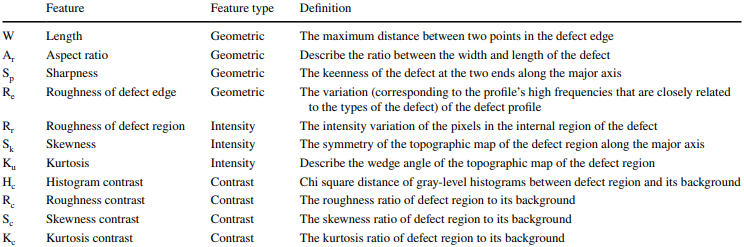

`Defect Types:`  
- `CR` = crack
- `LF` = lack of fusion
- `LP` = lack of penetration
- `PO` = porosity
- `SL` = slag inclusion

Useing `.info()` and `.describe()` for data confirmation and reference:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   w        219 non-null    float64
 1   ar       219 non-null    float64
 2   sp       219 non-null    float64
 3   re       219 non-null    float64
 4   rr       219 non-null    float64
 5   sk       219 non-null    float64
 6   ku       219 non-null    float64
 7   hc       219 non-null    float64
 8   rc       219 non-null    float64
 9   sc       219 non-null    float64
 10  kc       219 non-null    float64
 11  type_PO  219 non-null    uint8  
 12  type_SL  219 non-null    uint8  
 13  type_LP  219 non-null    uint8  
 14  type_LF  219 non-null    uint8  
 15  type_CR  219 non-null    uint8  
dtypes: float64(11), uint8(5)
memory usage: 20.0 KB


In [5]:
df[nums].describe()


,w,ar,sp,re,rr,sk,ku,hc,rc,sc,kc
count,2.190000e+02,2.190000e+02,2.190000e+02,2.190000e+02,2.190000e+02,2.190000e+02,2.190000e+02,2.190000e+02,2.190000e+02,2.190000e+02,2.190000e+02
mean,-8.111218e-18,-3.244487e-17,1.662800e-16,-9.733462e-17,-6.083414e-18,-7.502877e-17,1.022014e-15,3.244487e-17,-4.461170e-17,9.125121e-17,-4.866731e-17
std,1.002291e+00,1.002291e+00,1.002291e+00,1.002291e+00,1.002291e+00,1.002291e+00,1.002291e+00,1.002291e+00,1.002291e+00,1.002291e+00,1.002291e+00
min,-9.118320e-01,-8.000944e-01,-2.658791e+00,-1.475707e+00,-1.198802e+00,-1.012763e+00,-2.886221e+00,-6.694647e-01,-1.228245e+00,-1.672119e+00,-2.987224e+00
25%,-7.254280e-01,-7.653339e-01,-8.526988e-01,-9.823347e-01,-7.802472e-01,-6.275409e-01,-5.615597e-01,-5.772531e-01,-6.256668e-01,-6.639940e-01,-7.075824e-01
50%,-5.091975e-01,-5.683864e-01,-5.883228e-02,6.654728e-02,-1.722487e-01,-3.363570e-01,-2.232333e-01,-4.229268e-01,-3.357616e-01,-1.781106e-01,2.536041e-02
75%,5.272102e-01,6.058740e-01,1.049620e+00,7.977667e-01,4.401597e-01,1.959837e-01,4.299905e-01,1.516094e-01,2.171876e-01,5.471275e-01,6.215435e-01
max,4.285127e+00,3.236178e+00,1.974872e+00,2.324728e+00,3.618412e+00,5.087585e+00,3.966286e+00,6.907185e+00,4.537491e+00,5.315733e+00,3.629988e+00


In [6]:
# sns.pairplot(df, vars=nums, hue='type', diag_kind='kde')

<Axes: >

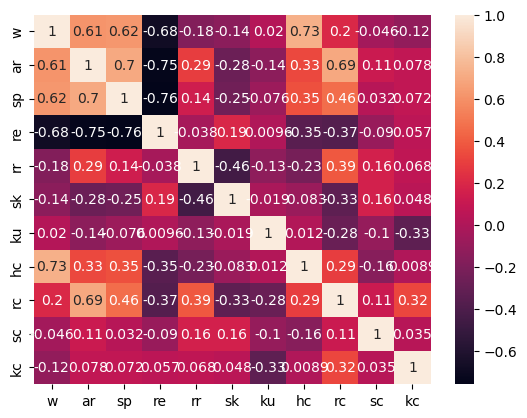

In [7]:
sns.heatmap(df[nums].corr(), annot=True)

# 2 &nbsp; `Train`

We will begin by splitting our data into training and testing sets, using a 20% test size:

In [8]:
X = df.select_dtypes(include=['float64']).values
Y = df.select_dtypes(include=['uint8']).values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape} Type: {type(X_train)}')
print(f'X_test  shape: {X_test.shape}  Type: {type(X_test)}')
print(f'y_train shape: {Y_train.shape}  Type: {type(Y_train)}')
print(f'y_test  shape: {Y_test.shape}   Type: {type(Y_test)}')

n_features = X.shape[1]
n_classes = Y.shape[1]
print('number of features: ', n_features)
print('number of classes : ', n_classes)

X_train shape: (175, 11) Type: <class 'numpy.ndarray'>
X_test  shape: (44, 11)  Type: <class 'numpy.ndarray'>
y_train shape: (175, 5)  Type: <class 'numpy.ndarray'>
y_test  shape: (44, 5)   Type: <class 'numpy.ndarray'>
number of features:  11
number of classes :  5


Construct basic artificial neural network (ANN) model with Keras:

explain why relu and sigmoid - sigmoid needed for outet - relu needed earlier due to vanishing gradient problem it does best on (as in reaserch paper)

We will create a functioin of a basic ANN model and then created differenent instances basese on different params, skips, etc.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 11)]         0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 6)            72          ['input_2[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 5)            35          ['dense_6[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 5)            30          ['dense_7[0][0]']                
                                                                                              

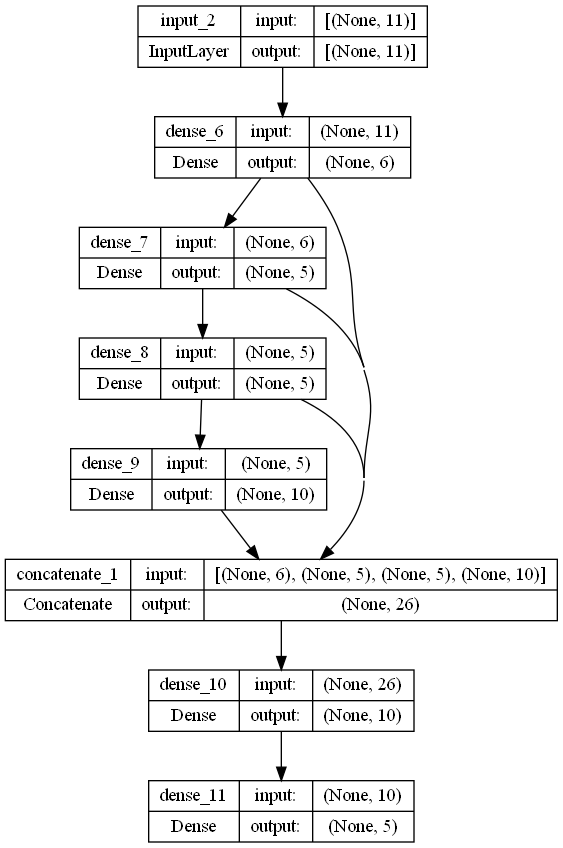

In [18]:
# def create_keras_model(input_dim, output_dim, nodes=5, n_hidden=1, name='model'):
#     '''
#     How to call:
#     myModel = create_keras_model(n_features, n_classes, nodes=5, n=1, name='model')
#     '''
#     # Create model
#     model = Sequential(name=name)
#     model.add(Dense(units=nodes,
#                     input_dim=input_dim,
#                     activation='relu',
#                     kernel_initializer='random_normal'
#                    )
#              )
#     # add HIDDEN layers to the network:
#     for i in range(n_hidden):
#         model.add(Dense(units=nodes,
#                         activation='relu',
#                         kernel_initializer='random_normal'
#                        )
#                  )
#     # OUTPUT layer:
#     model.add(Dense(output_dim, 
#                     activation='softmax', #  sigmoid
#                    )
#              )
    
#     model.compile(optimizer='adam', #  sgd
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy']
#                  )
    
#     return model


# def create_keras_model(input_dim, output_dim, nodes=5, n_hidden=4, name='model'):
#     '''
#     How to call:
#     myModel = create_keras_model(n_features, n_classes, nodes=5, n=4, name='model')
#     '''

#     # define input layer
#     inputs = Input(shape=(input_dim,))

#     # list to hold all the hidden layers
#     hidden_layers = []

#     # create the hidden layers
#     for i in range(n_hidden):
#         if i == 0:
#             # if it's the first hidden layer, connect it to the inputs
#             hidden_layers.append(Dense(units=nodes, activation='relu', kernel_initializer='random_normal')(inputs))
#         else:
#             # otherwise, connect it to the previous hidden layer
#             hidden_layers.append(Dense(units=nodes, activation='relu', kernel_initializer='random_normal')(hidden_layers[-1]))
            
#     # create the final hidden layer, connected to all previous hidden layers
#     final_hidden = Dense(units=nodes, activation='relu', kernel_initializer='random_normal')(concatenate(hidden_layers))

#     # create output layer connected to the final hidden layer
#     outputs = Dense(output_dim, activation='softmax')(final_hidden)

#     # create model
#     model = Model(inputs=inputs, outputs=outputs, name=name)

#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#     return model

# def create_keras_model(input_dim=11, output_dim=5, nodes=5, n_hidden=4, name='model'):
#     '''
#     How to call:
#     myModel = create_keras_model(n_features, n_classes, nodes=5, n=4, name='model')
#     '''

#     # define input layer
#     inputs = Input(shape=(input_dim,))

#     # list to hold all the hidden layers
#     hidden_layers = []

#     # create the hidden layers
#     for i in range(n_hidden-1):
#         if i == 0:
#             # if it's the first hidden layer, connect it to the inputs
#             hidden_layers.append(Dense(units=nodes, activation='relu', kernel_initializer='random_normal')(inputs))
#         else:
#             # otherwise, connect it to the previous hidden layer
#             hidden_layers.append(Dense(units=nodes, activation='relu', kernel_initializer='random_normal')(hidden_layers[-1]))
            
#     # create the final hidden layer, connected to all previous hidden layers
#     final_hidden = Dense(units=nodes, activation='relu', kernel_initializer='random_normal')(concatenate(hidden_layers))

#     # create output layer connected to the final hidden layer
#     outputs = Dense(output_dim, activation='softmax')(final_hidden)

#     # create model
#     model = Model(inputs=inputs, outputs=outputs)

#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#     return model

def create_keras_model(input_dim=11, output_dim=5, hidden_nodes=[5, 10, 15], name='model'):
    '''
    How to call:
    myModel = create_keras_model(n_features, n_classes, hidden_nodes=[5, 10, 15], name='model')
    '''
    np.random.seed(42)
    tf.random.set_seed(42)

    # define input layer
    inputs = Input(shape=(input_dim,))

    # list to hold all the hidden layers
    hidden_layers = []

    # create the hidden layers
    for i in range(len(hidden_nodes)):
        if i == 0:
            # if it's the first hidden layer, connect it to the inputs
            hidden_layers.append(Dense(units=hidden_nodes[i], activation='relu', kernel_initializer='random_normal')(inputs))
        else:
            # otherwise, connect it to the previous hidden layer
            hidden_layers.append(Dense(units=hidden_nodes[i], activation='relu', kernel_initializer='random_normal')(hidden_layers[-1]))
            
    # create the final hidden layer, connected to all previous hidden layers
    final_hidden = Dense(units=hidden_nodes[-1], activation='relu', kernel_initializer='random_normal')(concatenate(hidden_layers))

    # create output layer connected to the final hidden layer
    outputs = Dense(output_dim, activation='softmax')(final_hidden)

    # create model
    model = Model(inputs=inputs, outputs=outputs, name=name)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model0 = create_keras_model(n_features, n_classes, hidden_nodes=[6, 5, 5, 10], name='model')
model0.summary()
plot_model(model0, show_shapes=True)


# COMPRSSED MODEL
# from tensorflow.keras.layers import Input, Dense, concatenate
# from tensorflow.keras.models import Model

# def create_keras_model(input_dim=11, output_dim=5, hidden_nodes=[[5, 2], [10, 4], [15, 8]], name='model'):
#     '''
#     How to call:
#     myModel = create_keras_model(n_features, n_classes, hidden_nodes=[[5, 2], [10, 4], [15, 8]], name='model')
#     '''

#     # define input layer
#     inputs = Input(shape=(input_dim,))

#     # list to hold all the hidden layers
#     hidden_layers = []
#     compressed_layers = []

#     # create the hidden layers
#     for i in range(len(hidden_nodes)):
#         if i == 0:
#             # if it's the first hidden layer, connect it to the inputs
#             hidden_layers.append(Dense(units=hidden_nodes[i][0], activation='relu', kernel_initializer='random_normal')(inputs))
#         else:
#             # otherwise, connect it to the previous hidden layer
#             hidden_layers.append(Dense(units=hidden_nodes[i][0], activation='relu', kernel_initializer='random_normal')(hidden_layers[-1]))
        
#         # create compression layer
#         compressed_layers.append(Dense(units=hidden_nodes[i][1], activation='relu', kernel_initializer='random_normal')(hidden_layers[-1]))

#     # create the final hidden layer, connected to all compression layers
#     final_hidden = Dense(units=hidden_nodes[-1][1], activation='relu', kernel_initializer='random_normal')(concatenate(compressed_layers))

#     # create output layer connected to the final hidden layer
#     outputs = Dense(output_dim, activation='softmax')(final_hidden)

#     # create model
#     model = Model(inputs=inputs, outputs=outputs, name=name)

#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#     return model

# model0 = create_keras_model(n_features, n_classes, hidden_nodes=[[6, 3], [5, 3], [5, 4]], name='model')
# model0.summary()
# plot_model(model0, show_shapes=True)





In [10]:
model0firstfit = model0.fit(X_train, Y_train, batch_size=32, epochs=400, verbose=0, validation_data=(X_test, Y_test))

In [11]:
# model0.metrics_names


# score = model0.evaluate(X_test, Y_test, verbose=1)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])


# fig, (ax1, ax2) = plt.subplots(2, figsize=(9, 8))

# val_accurady = model0firstfit.history['val_accuracy']
# val_loss = model0firstfit.history['val_loss']
# ax1.plot(val_accurady)
# ax2.plot(val_loss)
    
# ax1.set_ylabel('Validation Accuracy')
# ax2.set_ylabel('Validation Loss')
# ax2.set_xlabel('epochs')

(0.0, 1.6862585127353669)

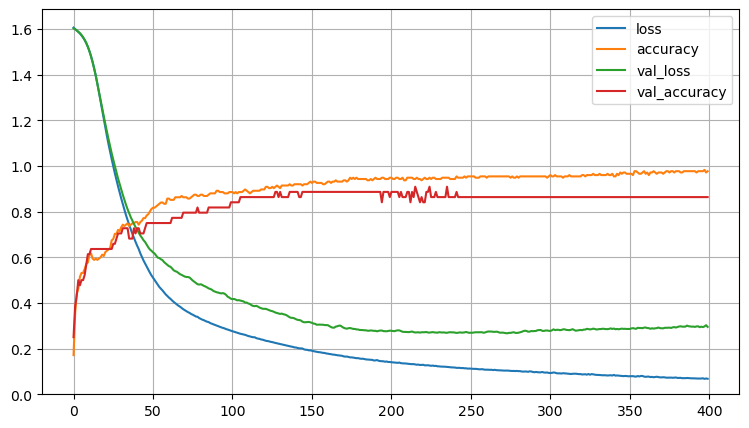

In [12]:
maxes = []
for met in model0firstfit.history.keys():
    maxes.append(max(model0firstfit.history[met]))
mmax = max(maxes)

pd.DataFrame(model0firstfit.history).plot(figsize=(9, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.05*mmax) # set the vertical range to [0-1] plt.show()

In [13]:
# # Wrap Keras model with KerasClassifier
# model = KerasClassifier(build_fn=create_keras_model, verbose=0)


# # set parameters
# batch_size = [10, 30]
# epochs = [20, 200]
# param_grid = dict(batch_size=batch_size, epochs=epochs)

# # Create Grid Search
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2)
# grid_result = grid.fit(X_train, Y_train)

# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [14]:
# # create dataframe from cv_results_
# df = pd.DataFrame(grid_result.cv_results_)

# # pivot as prep for heatmap
# df_pivot = df.pivot(index='param_batch_size', columns='param_epochs', values='mean_test_score')

# # create heatmap
# fig, ax = plt.subplots(figsize=(9, 5))
# sns.heatmap(df_pivot, annot=True, cmap="YlGnBu")
# ax.set_title('Accuracy Heatmap')
# ax.set_ylabel('Batch Size')
# ax.set_xlabel('Epochs')

2/2 [==============================] - 0s 3ms/step


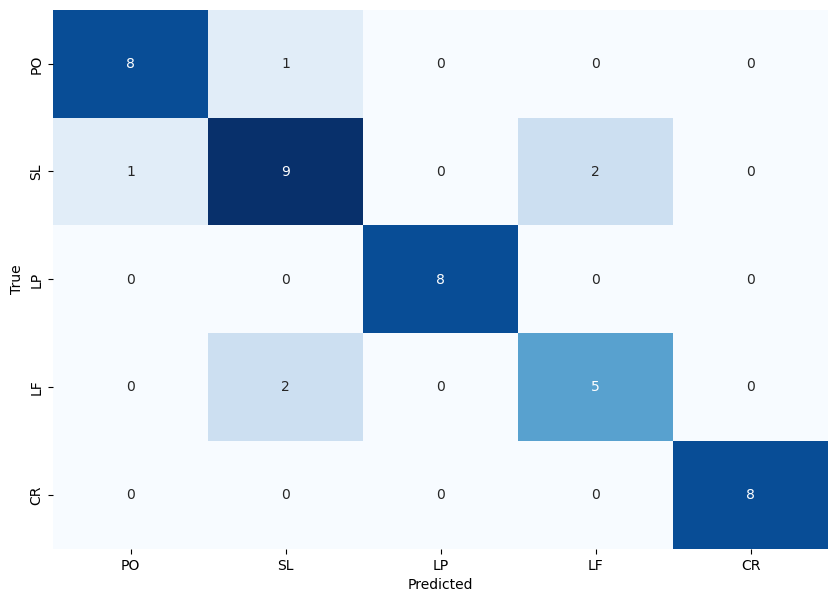

In [15]:
# from sklearn.metrics import accuracy_score

# # get predictions
# y_pred = grid.predict(X_test)

# # get accuracy
# acc = accuracy_score(Y_test, y_pred)

# # print accuracy
# print('Accuracy:', acc)

# # print best parameters
# print('Best Parameters:', grid.best_params_)


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# predict classes for test set
Y_pred = model0.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

# convert one-hot encoded test labels back to class labels
y_true = np.argmax(Y_test, axis=1)

# calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=types, yticklabels=types)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [16]:
from sklearn.metrics import classification_report

# print classification report
print(classification_report(y_true, y_pred, target_names=types))

              precision    recall  f1-score   support

          PO       0.89      0.89      0.89         9
          SL       0.75      0.75      0.75        12
          LP       1.00      1.00      1.00         8
          LF       0.71      0.71      0.71         7
          CR       1.00      1.00      1.00         8

    accuracy                           0.86        44
   macro avg       0.87      0.87      0.87        44
weighted avg       0.86      0.86      0.86        44



In [17]:
end_time = time.time()
print(f'Total runtime of this notebook is {(end_time-start_time)/60:0.2f} minutes.')

Total runtime of this notebook is 0.49 minutes.
